In [ ]:
import numpy as np
import pandas as pd

from eval_utils import *
from model_evaluation import *

from sklearn.model_selection import GridSearchCV, KFold
from timeit import default_timer as timer

from skopt import BayesSearchCV
from skopt.space import Integer, Real
from sklearn.model_selection import KFold
from xgboost import XGBRegressor

# from sklearn.model_selection import GridSearchCV, KFold
# from timeit import default_timer as timer

# from skopt import BayesSearchCV
# from skopt.space import Integer, Real
# from sklearn.model_selection import KFold
# from xgboost import XGBRegressor


import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('train.csv')

df.columns = df.columns.str.strip().str.replace(" ", "_")

## Препроцессинг

Добавим признаки, полученные после feature engineering

In [3]:
def create_income_bins(X_train, X_test, feature='Annual_Income'):
    """
    Создает Income_Group 
    Fit на train, transform на test
    """
    labels = ["Low Income", "Mid-Low", "Mid-High", "High Income"]
    
    # Получаем границы только из train
    _, bins = pd.qcut(X_train[feature], q=4, labels=labels, retbins=True, duplicates='drop')
    
    # Расширяем границы для покрытия test
    bins[0] = -np.inf
    bins[-1] = np.inf
    
    # Применяем к обоим
    X_train["Income_Group"] = pd.cut(X_train[feature], bins=bins, labels=labels, include_lowest=True)
    X_test["Income_Group"] = pd.cut(X_test[feature], bins=bins, labels=labels, include_lowest=True)
    
    return X_train, X_test

def create_health_bins(X_train, X_test, feature='Health_Score'):
    """
    Создает Health_Score
    Fit на train, transform на test
    """
    labels = ["High Risk", "Medium Risk", "Low Risk"]
    
    # Получаем границы только из train
    _, bins = pd.qcut(X_train[feature], q=3, labels=labels, retbins=True, duplicates='drop')
    
    # Расширяем границы для покрытия test
    bins[0] = -np.inf
    bins[-1] = np.inf
    
    # Применяем к обоим
    X_train["Health_Risk_Level"] = pd.cut(X_train[feature], bins=bins, labels=labels, include_lowest=True)
    X_test["Health_Risk_Level"] = pd.cut(X_test[feature], bins=bins, labels=labels, include_lowest=True)
    
    return X_train, X_test

def create_interaction_features(df):
    """
    Добавляет взаимодействия признаков
    """
    df["Age_Health"] = df["Age"] * df["Health_Score"] #возраст и рейтинг здоровья

    df["VehicleAge_Claims"] = df["Vehicle_Age"] * df["Previous_Claims"] #возраст автомобиля и кол-во обращений клиента

    df["Health_Claims"] = df["Health_Score"] * df["Previous_Claims"] #рейтинг здоровья и кол-во обращений клиента

    return df

def create_date_features(df):
    """
    Создает временные признаки на основе даты начала полиса (Policy_Start_Date).

    Добавляемые признаки:
    - Day_of_week — день недели (0–6)
    - Week — номер недели в году
    - Year_sin, Year_cos — циклическое представление года
    - Month_sin, Month_cos — циклическое представление месяца
    - Day_sin, Day_cos — циклическое представление дня месяца
    - Group — агрегированный порядковый номер периода (грубо: неделя с 2020 года)
    - days_elapsed — количество дней, прошедших с минимальной даты в выборке
    """
    df['Day_of_week'] = df['Policy_Start_Date'].dt.dayofweek
    df['Week'] = df['Policy_Start_Date'].dt.isocalendar().week
    df['Year_sin'] = np.sin(2 * np.pi * df['Policy_Year'])
    df['Year_cos'] = np.cos(2 * np.pi * df['Policy_Year'])
    df['Month_sin'] = np.sin(2 * np.pi * df['Policy_Month'] / 12) 
    df['Month_cos'] = np.cos(2 * np.pi * df['Policy_Month'] / 12)
    df['Day_sin'] = np.sin(2 * np.pi * df['Policy_Day'] / 31)  
    df['Day_cos'] = np.cos(2 * np.pi * df['Policy_Day'] / 31)
    df['Group']=(df['Policy_Year']-2020)*48+df['Policy_Month']*4+df['Policy_Day']//7

    df['days_elapsed'] = (df['Policy_Start_Date'] -  df['Policy_Start_Date'].min()).dt.days

    return df

In [4]:
df["Policy_Start_Date"] = pd.to_datetime(df["Policy_Start_Date"])
df["Policy_Year"] = df["Policy_Start_Date"].dt.year
df["Policy_Month"] = df["Policy_Start_Date"].dt.month
df["Policy_Day"] = df["Policy_Start_Date"].dt.day


numerical_features = [
    'Age', 'Annual_Income', 'Number_of_Dependents', 'Health_Score',
    'Previous_Claims', 'Vehicle_Age', 'Credit_Score', 'Insurance_Duration',
    'Policy_Year', 'Policy_Month', 'Policy_Day',
    'Age_Health','VehicleAge_Claims','Health_Claims'
]

binary_features = ['Gender', 'Smoking_Status']
ordinal_features = ['Exercise_Frequency', 'Income_Group', 'Health_Risk_Level']
nominal_features = [
    'Marital_Status', 'Education_Level', 'Occupation',
    'Location', 'Policy_Type', 'Customer_Feedback', 'Property_Type'
]

In [5]:
df["Policy_Start_Date"] = pd.to_datetime(df["Policy_Start_Date"])
df["Policy_Year"] = df["Policy_Start_Date"].dt.year
df["Policy_Month"] = df["Policy_Start_Date"].dt.month
df["Policy_Day"] = df["Policy_Start_Date"].dt.day

X = df.drop(['Premium_Amount'], axis=1, errors='ignore')
y = np.log1p(df['Premium_Amount'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test = create_income_bins(X_train, X_test)
X_train, X_test = create_health_bins(X_train, X_test)

X_train = create_interaction_features(X_train)
X_test = create_interaction_features(X_test)


X_train = create_date_features(X_train)
X_test = create_date_features(X_test)


X_train_proc, X_test_proc, y_train, y_test = get_baseline_preprocessing(
    X_train, X_test, y_train, y_test,
    numerical_features, binary_features, ordinal_features, nominal_features
)


raw_results = run_experiment(X_train_proc, X_test_proc, y_train, y_test,
                                "Лучший результат (до подбора гипер-ов)")



ЭКСПЕРИМЕНТ: Лучший результат (до подбора гипер-ов)
Train shape: (960000, 44), Test shape: (240000, 44)
{'model': 'DecisionTreeRegressor', 'mse': 850731.8684407859, 'rmse': np.float64(922.351271718528), 'mae': 622.3354655914976, 'r2': -0.1384293826044749, 'rmsle': np.float64(1.0501849666877359)}

DecisionTreeRegressor - Кросс-валидация (5 folds)...
CV MSE: 852533.9122 (+/- 3859.8344)
CV RMSE: 923.3253 (+/- 2.0885)
CV RMSLE: 1.0498 (+/- 0.0018)
{'model': 'RandomForestRegressor', 'mse': 859024.76114228, 'rmse': np.float64(926.8358868442028), 'mae': 624.5044307840947, 'r2': -0.1495267366221047, 'rmsle': np.float64(1.0582657629071313)}

RandomForestRegressor - Кросс-валидация (5 folds)...
CV MSE: 860281.5216 (+/- 4016.1494)
CV RMSE: 927.5111 (+/- 2.1629)
CV RMSLE: 1.0571 (+/- 0.0021)
{'model': 'XGBoost', 'mse': 856336.5231815686, 'rmse': np.float64(925.3845272002167), 'mae': 623.9054729550679, 'r2': -0.14592939979315123, 'rmsle': np.float64(1.050233722799076)}

XGBoost - Кросс-валидация (

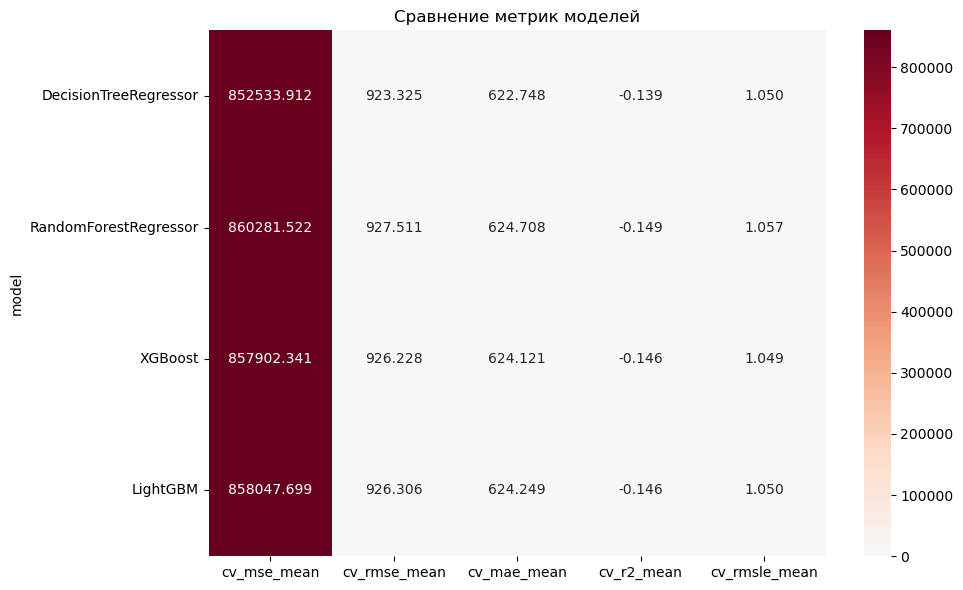

In [6]:
raw_metrics = compare_models_metrics(raw_results)

In [6]:
models = get_baseline_models()

In [7]:
print(models)

{'DecisionTreeRegressor': DecisionTreeRegressor(max_depth=10, min_samples_leaf=5, random_state=42), 'RandomForestRegressor': RandomForestRegressor(max_depth=5, n_estimators=10, random_state=42), 'XGBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=20,
             n_jobs=None, num_parallel_tree=None, ...), 'LightGBM': LGBMRegressor(max_depth=6, metric='

## GridSearchCV

Проведем подбор оптимальных гиперпараметров для модели XGBoost с помощью метода GridSearchCV, используя  кросс-валидацию (KFold).

Для подбора гиперпараметров определим сетку параметров, включающую скорость обучения (eta), глубину деревьев (max_depth) и количество деревьев (n_estimators).

В качестве базовой модели используем XGBRegressor, настроенный на использование метрики RMSE и с механизмом ранней остановки (early_stopping_rounds), чтобы избежать переобучения.

Кросс-валидация проводится на 5 фолдах с перемешиванием данных для повышения устойчивости результата.
Для обучения и валидации модели данные делятся в пропорции 80/20.

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    "eta": [0.01, 0.05, 0.1],
    "max_depth": [5, 10, 15, 20, 30],
    "n_estimators": [30, 50, 80, 100],
}

In [ ]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    early_stopping_rounds=50,
    random_state=42,
    n_jobs=1,
    device='cuda'
)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=cv,
    n_jobs=-1,
    verbose=3
)

# Разделяем на train/val
X_train_fit, X_val_fit, y_train_fit, y_val_fit = train_test_split(
    X_train_proc, y_train,
    test_size=0.2,
    random_state=42
)

fit_params = {
    'eval_set': [(X_val_fit, y_val_fit)],
    'verbose': False
}

grid_search.fit(X_train_proc, y_train, **fit_params)

In [ ]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    early_stopping_rounds=50,  # Останавливаемся, если нет улучшения 50 раундов
    random_state=42,
    n_jobs=4
)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=cv,
    n_jobs=4,
    verbose=3
)

# Создаем валидационный набор (20% от тренировочных данных)
from sklearn.model_selection import train_test_split

X_train_fit, X_val_fit, y_train_fit, y_val_fit = train_test_split(
    X_train_proc, y_train, 
    test_size=0.2, 
    random_state=42
)

# Параметры для fit (валидационный набор для early stopping)
fit_params = {
    'eval_set': [(X_val_fit, y_val_fit)],
    'verbose': False
}


grid_search.fit(X_train_proc, y_train, **fit_params)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


KeyboardInterrupt: 

Подбор проводился в ноутбуке кэггла с использованием gpu, так что тут будут приведены сразу гипер-ры

In [17]:
best_params = {'eta': 0.05, 'max_depth': 10, 'n_estimators': 80}

In [ ]:
best_model = XGBRegressor(
    objective='reg:squarederror',
    **best_params
)

metrics_gridcv = evaluate_model(best_model, X_train_proc, X_test_proc, y_train, y_test, "XGBoost", use_cv=False)

{'model': 'XGBoost', 'mse': 849994.3690015594, 'rmse': np.float64(921.9513918865568), 'mae': 621.2555792009035, 'r2': -0.13744247819614652, 'rmsle': np.float64(1.0472298649253768)}


In [26]:
metrics_gridcv

{'model': 'XGBoost',
 'mse': 849994.3690015594,
 'rmse': np.float64(921.9513918865568),
 'mae': 621.2555792009035,
 'r2': -0.13744247819614652,
 'rmsle': np.float64(1.0472298649253768)}

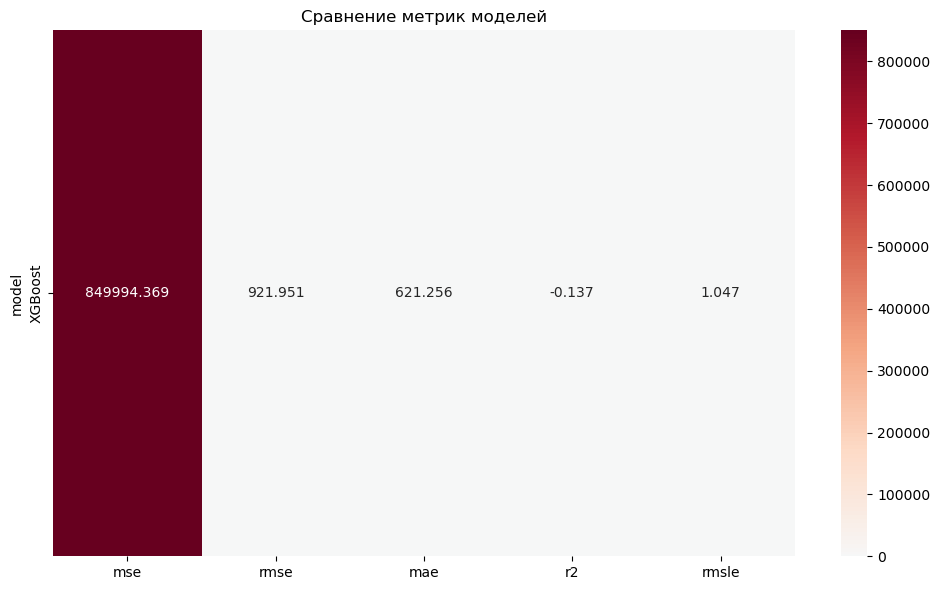

,mse,rmse,mae,r2,rmsle
model,,,,,
XGBoost,-6342.15418,-3.433135,-2.649894,0.008487,-0.003004


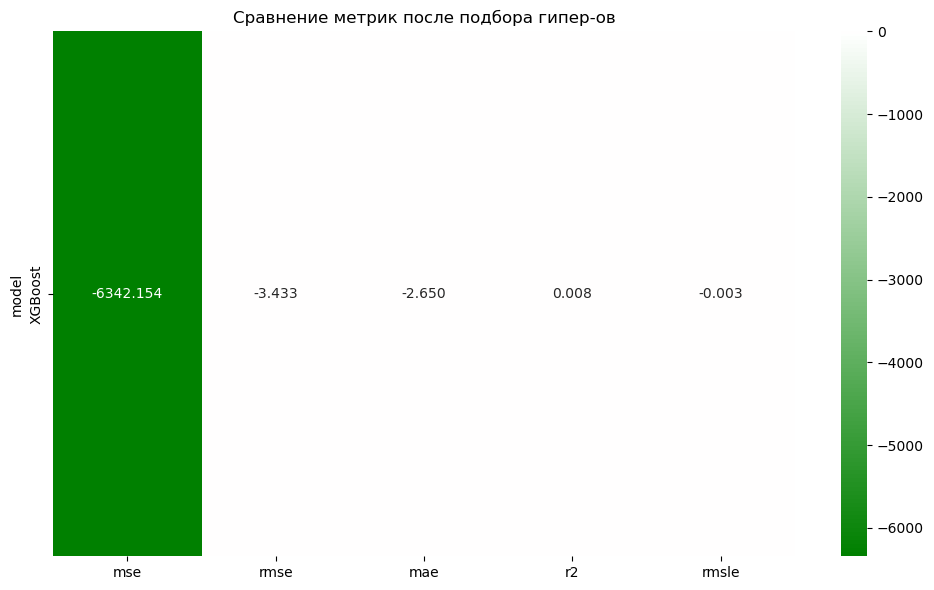

In [29]:
m = compare_models_metrics([metrics_gridcv], metrics_to_compare=['mse', 'rmse', 'mae', 'r2', 'rmsle'])
compare_after_add(m, raw_metrics.iloc[[2]], 'Сравнение метрик после подбора гипер-ов', metrics_to_compare=['mse', 'rmse', 'mae', 'r2', 'rmsle'], normalize=False)

Видим что снизился MSE на 6 тыс., и совсем незначительно RMSLE на 0.003

Проведем аналогичный подбор с помощью байесовской оптимизации (BayesSearchCV)

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

param_space = {
    "learning_rate": Real(0.01, 0.1, prior='log-uniform'),
    "max_depth": Integer(5, 20),
    "n_estimators": Integer(100, 300),  
}

# валидационный набор для early stopping
X_train_fit, X_val_fit, y_train_fit, y_val_fit = train_test_split(
    X_train_proc, y_train, 
    test_size=0.2, 
    random_state=42
)

xgb_gpu = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    early_stopping_rounds=50,  # Останавливаемся, если нет улучшения 50 раундов
    random_state=42,
    device='cuda',
    n_jobs=1
)

# Параметры для fit (валидационный набор для early stopping)
fit_params = {
    'eval_set': [(X_val_fit, y_val_fit)],
    'verbose': False
}

bayes_search = BayesSearchCV(
    estimator=xgb_gpu,
    search_spaces=param_space,
    scoring='neg_root_mean_squared_error',
    n_jobs=1, 
    cv=cv,
    n_iter=10,
    random_state=42,
    verbose=3
)

bayes_search.fit(X_train_proc, y_train, **fit_params)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Exception ignored on calling ctypes callback function <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x000001999D3FF0B0>>:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py", line 585, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument
KeyboardInterrupt: 


XGBoostError: [19:09:18] C:\actions-runner\_work\xgboost\xgboost\src\data\quantile_dmatrix.cc:174: Check failed: accumulated_rows == info.num_row_ (1536000 vs. 768000) : 

Также загрузим параметры, т.к. подбор проводился не в этом ноутбуке

In [31]:
from collections import OrderedDict

params = OrderedDict([
    ('learning_rate', 0.0649226126117357),
    ('max_depth', 8),
    ('n_estimators', 220)
])

print(params)


OrderedDict({'learning_rate': 0.0649226126117357, 'max_depth': 8, 'n_estimators': 220})


{'model': 'XGBoost', 'mse': 850198.9670946256, 'rmse': np.float64(922.0623444727723), 'mae': 621.3987584899266, 'r2': -0.13771626655345615, 'rmsle': np.float64(1.0470259039958862)}


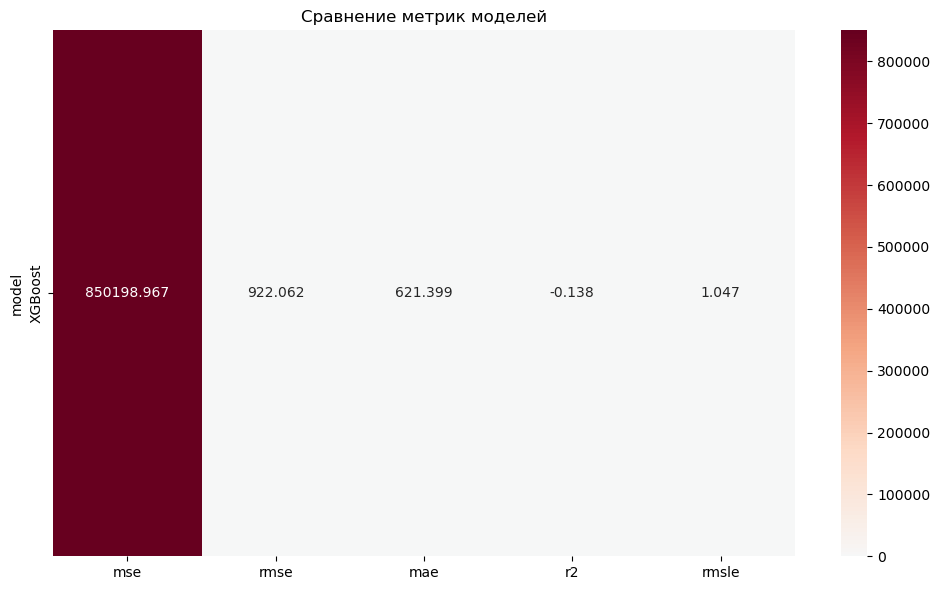

,mse,rmse,mae,r2,rmsle
model,,,,,
XGBoost,-6137.556087,-3.322183,-2.506714,0.008213,-0.003208


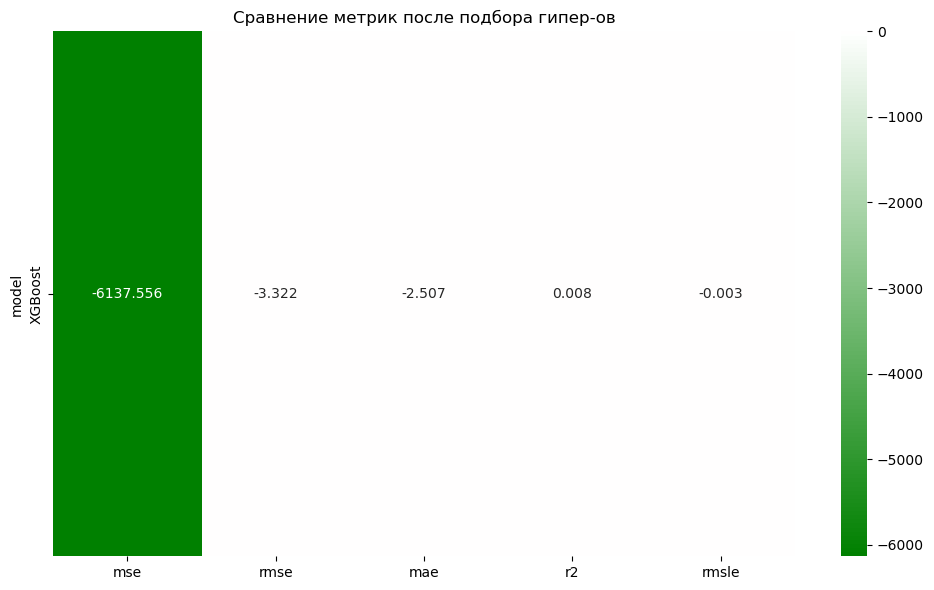

In [33]:
best_model = XGBRegressor(
    objective='reg:squarederror',
    **params
)

metrics_bayes = evaluate_model(best_model, X_train_proc, X_test_proc, y_train, y_test, "XGBoost", use_cv=False)

m = compare_models_metrics([metrics_bayes], metrics_to_compare=['mse', 'rmse', 'mae', 'r2', 'rmsle'])
compare_after_add(m, raw_metrics.iloc[[2]], 'Сравнение метрик после подбора гипер-ов', metrics_to_compare=['mse', 'rmse', 'mae', 'r2', 'rmsle'], normalize=False)

В этом случае получили почти аналогичные grid search подбору результаты

**Вывод**: таким образом, подбор гиперпараметров не дал каких то значимых изменений, снизился RMSLE на 0.003 и MSE на 6 тыс по отношению к модели XGBoost, которая была обучена после добавления новых признаков